# Red Pill Content Analysis and Insights

In [1]:
!pip install isodate nltk wordcloud

In [2]:
import pandas as pd
import numpy as np
import time
import isodate
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from dateutil import parser
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bashaardhoot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bashaardhoot/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
video_df = pd.read_csv("dataFolder/redPillAnalytics.csv")

In [30]:
df1 = pd.read_csv("dataFolder/commentsBatchOne_df.csv")
df2 = pd.read_csv("dataFolder/commentsBatchTwo_df.csv")

In [31]:
comments_df = pd.concat([df1, df2], ignore_index=True)

In [5]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,F5eSaabAAmk,Benjamin Seda,How to ACTUALLY Get a Girlfriend in 2025 (Full...,👉🏼 Get 1-3+ dates per week in 30 days (coachin...,"['how to flirt with a girl', 'dates', 'how to ...",2025-03-06T15:27:49Z,5034,254.0,NaN,27.0,PT15M4S,hd,False
1,xJ6b8CV-pQ0,Benjamin Seda,How to Find A 10/10 Girlfriend,👫 My 3 step formula to approach & attract wome...,"['how to flirt with a girl', 'dates', 'how to ...",2025-03-03T15:01:24Z,3346,330.0,NaN,22.0,PT59S,hd,False
2,kPhrei5S88U,Benjamin Seda,The Mistake 99% of Men Make That Keep Them Single,👫 My 3 step formula to approach & attract wome...,"['how to flirt with a girl', 'dates', 'how to ...",2025-03-01T14:45:07Z,2690,222.0,NaN,19.0,PT36S,hd,False
3,4ZnwTwLcAeM,Benjamin Seda,How to Always Get That 2nd Date,👫 My 3 step formula to approach & attract wome...,"['how to flirt with a girl', 'dates', 'how to ...",2025-02-27T14:15:00Z,4060,413.0,NaN,9.0,PT46S,hd,False
4,VW9-SBs6yIg,Benjamin Seda,The Donald Trump Method for Tinder (STEAL THIS),👫 My 3 step formula to approach & attract wome...,"['how to flirt with a girl', 'dates', 'how to ...",2025-02-26T13:45:03Z,6818,316.0,NaN,30.0,PT32S,hd,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13670,_X4P6L622-8,The Corbett Report (Unofficial),How Do I Defend Voluntarism? - Questions For C...,I have no affiliation with James Corbett or Th...,NaN,2022-05-25T13:22:06Z,393,15.0,NaN,2.0,PT28M13S,hd,False
13671,tkmZ4c2AOVY,The Corbett Report (Unofficial),The 5G Dragnet,I have no affiliation with James Corbett or Th...,NaN,2022-05-24T17:28:15Z,1226,61.0,NaN,2.0,PT25M44S,sd,False
13672,mr7itEUIVew,The Corbett Report (Unofficial),False Flags: The Secret History of Al Qaeda — ...,I have no affiliation with James Corbett or Th...,NaN,2022-05-24T17:01:10Z,5531,179.0,NaN,16.0,PT1H16M19S,sd,False
13673,ochRNyIDTE8,The Corbett Report (Unofficial),Episode 409 - False Flags: The Secret History ...,I have no affiliation with James Corbett or Th...,NaN,2022-05-24T17:01:06Z,6132,212.0,NaN,16.0,PT1H59M39S,sd,False


In [32]:
comments_df

,video_id,comment,published_at
0,OVIC-6QRIGI,Men have to be 6 ft multimillionaires to get ...,2025-03-09T12:04:38Z
1,OVIC-6QRIGI,Can’t believe this pod is still on.,2025-03-09T10:58:29Z
2,OVIC-6QRIGI,YT needs to stop this censorship nonsense smh,2025-03-09T05:25:19Z
3,OVIC-6QRIGI,These long nails are so ugly….women don’t see ...,2025-03-09T04:10:56Z
4,OVIC-6QRIGI,"Wow kamala voter just a dead NPC \nSOULLESS, n...",2025-03-09T03:54:54Z
...,...,...,...
669609,cIoiNZC1K7s,Best channel ..you are love guru,2018-12-09T18:03:34Z
669610,cIoiNZC1K7s,2018??,2018-11-28T09:39:10Z
669611,cIoiNZC1K7s,Over 9000,2018-11-18T11:04:31Z
669612,cIoiNZC1K7s,Should you approach her when there's other peo...,2018-11-07T20:37:51Z


In [6]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description        True
tags               True
publishedAt       False
viewCount         False
likeCount          True
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [7]:
video_df.publishedAt.sort_values().value_counts()

publishedAt
2023-04-04T20:00:14Z    2
2023-02-17T21:00:09Z    2
2023-02-02T21:00:26Z    2
2023-05-29T20:00:03Z    2
2024-11-27T22:00:31Z    2
                       ..
2021-10-20T02:38:03Z    1
2021-10-20T02:54:38Z    1
2021-10-20T05:51:59Z    1
2021-10-20T14:00:33Z    1
2025-03-07T16:00:27Z    1
Name: count, Length: 13652, dtype: int64

In [8]:
cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[cols] = video_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [9]:
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [10]:
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [12]:
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None or pd.isna(x) else len(x))

In [13]:
video_df['likeRatio'] = video_df['likeCount']/ video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount']/ video_df['viewCount'] * 1000

In [14]:
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

In [16]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagsCount,likeRatio,commentRatio,titleLength
0,F5eSaabAAmk,Benjamin Seda,How to ACTUALLY Get a Girlfriend in 2025 (Full...,👉🏼 Get 1-3+ dates per week in 30 days (coachin...,"['how to flirt with a girl', 'dates', 'how to ...",2025-03-06 15:27:49+00:00,5034.0,254.0,NaN,27.0,PT15M4S,hd,False,Thursday,0 days 00:15:04,424,50.456893,5.363528,53
1,xJ6b8CV-pQ0,Benjamin Seda,How to Find A 10/10 Girlfriend,👫 My 3 step formula to approach & attract wome...,"['how to flirt with a girl', 'dates', 'how to ...",2025-03-03 15:01:24+00:00,3346.0,330.0,NaN,22.0,PT59S,hd,False,Monday,0 days 00:00:59,282,98.625224,6.575015,30
2,kPhrei5S88U,Benjamin Seda,The Mistake 99% of Men Make That Keep Them Single,👫 My 3 step formula to approach & attract wome...,"['how to flirt with a girl', 'dates', 'how to ...",2025-03-01 14:45:07+00:00,2690.0,222.0,NaN,19.0,PT36S,hd,False,Saturday,0 days 00:00:36,282,82.527881,7.063197,49
3,4ZnwTwLcAeM,Benjamin Seda,How to Always Get That 2nd Date,👫 My 3 step formula to approach & attract wome...,"['how to flirt with a girl', 'dates', 'how to ...",2025-02-27 14:15:00+00:00,4060.0,413.0,NaN,9.0,PT46S,hd,False,Thursday,0 days 00:00:46,282,101.724138,2.216749,31
4,VW9-SBs6yIg,Benjamin Seda,The Donald Trump Method for Tinder (STEAL THIS),👫 My 3 step formula to approach & attract wome...,"['how to flirt with a girl', 'dates', 'how to ...",2025-02-26 13:45:03+00:00,6818.0,316.0,NaN,30.0,PT32S,hd,False,Wednesday,0 days 00:00:32,282,46.347903,4.400117,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13670,_X4P6L622-8,The Corbett Report (Unofficial),How Do I Defend Voluntarism? - Questions For C...,I have no affiliation with James Corbett or Th...,NaN,2022-05-25 13:22:06+00:00,393.0,15.0,NaN,2.0,PT28M13S,hd,False,Wednesday,0 days 00:28:13,0,38.167939,5.089059,52
13671,tkmZ4c2AOVY,The Corbett Report (Unofficial),The 5G Dragnet,I have no affiliation with James Corbett or Th...,NaN,2022-05-24 17:28:15+00:00,1226.0,61.0,NaN,2.0,PT25M44S,sd,False,Tuesday,0 days 00:25:44,0,49.755302,1.631321,14
13672,mr7itEUIVew,The Corbett Report (Unofficial),False Flags: The Secret History of Al Qaeda — ...,I have no affiliation with James Corbett or Th...,NaN,2022-05-24 17:01:10+00:00,5531.0,179.0,NaN,16.0,PT1H16M19S,sd,False,Tuesday,0 days 01:16:19,0,32.363045,2.892786,66
13673,ochRNyIDTE8,The Corbett Report (Unofficial),Episode 409 - False Flags: The Secret History ...,I have no affiliation with James Corbett or Th...,NaN,2022-05-24 17:01:06+00:00,6132.0,212.0,NaN,16.0,PT1H59M39S,sd,False,Tuesday,0 days 01:59:39,0,34.572733,2.609263,72


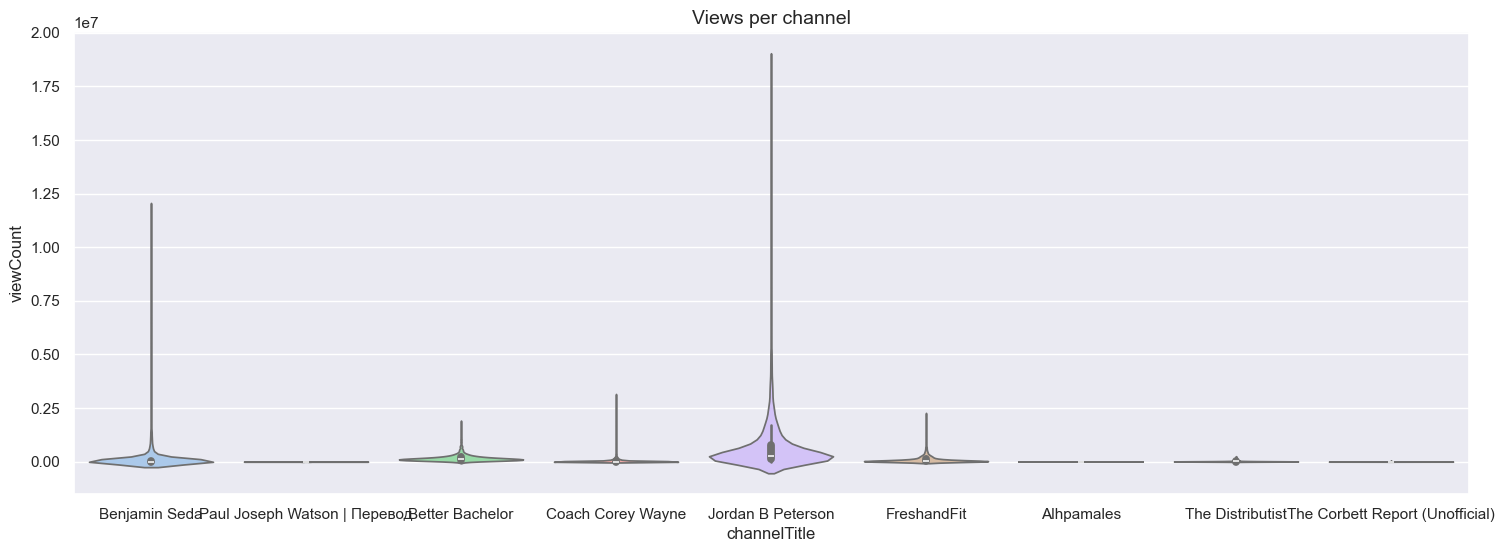

In [18]:
plt.rcParams['figure.figsize'] = (18, 6)
sns.violinplot(x='channelTitle', y='viewCount', data=video_df, hue='channelTitle', palette='pastel', legend=False)
plt.title('Views per channel', fontsize=14)
plt.show()

<Axes: xlabel='likeCount', ylabel='viewCount'>

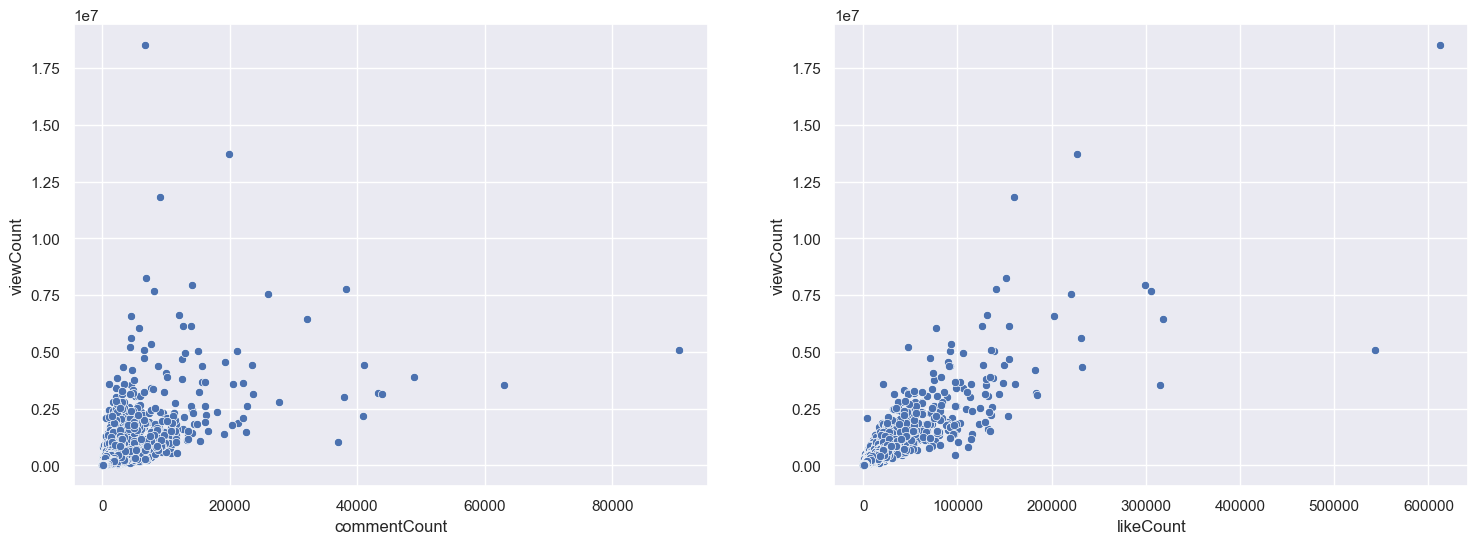

In [19]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])

<Axes: xlabel='likeRatio', ylabel='viewCount'>

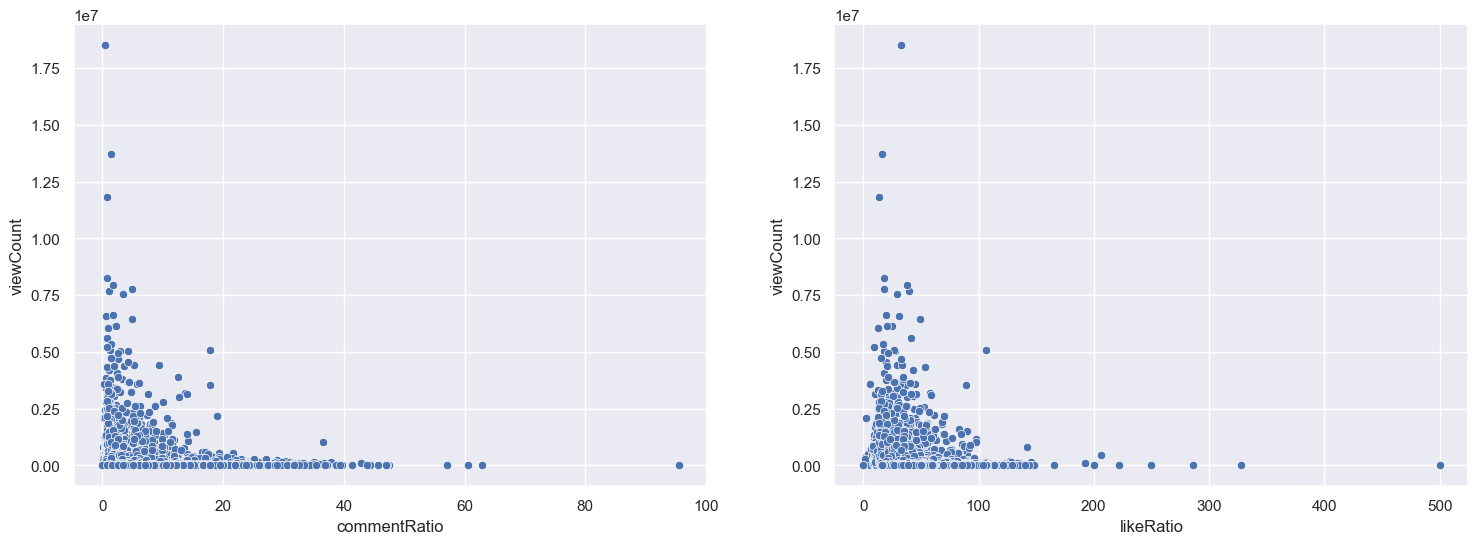

In [20]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[1])

<Axes: xlabel='durationSecs', ylabel='Count'>

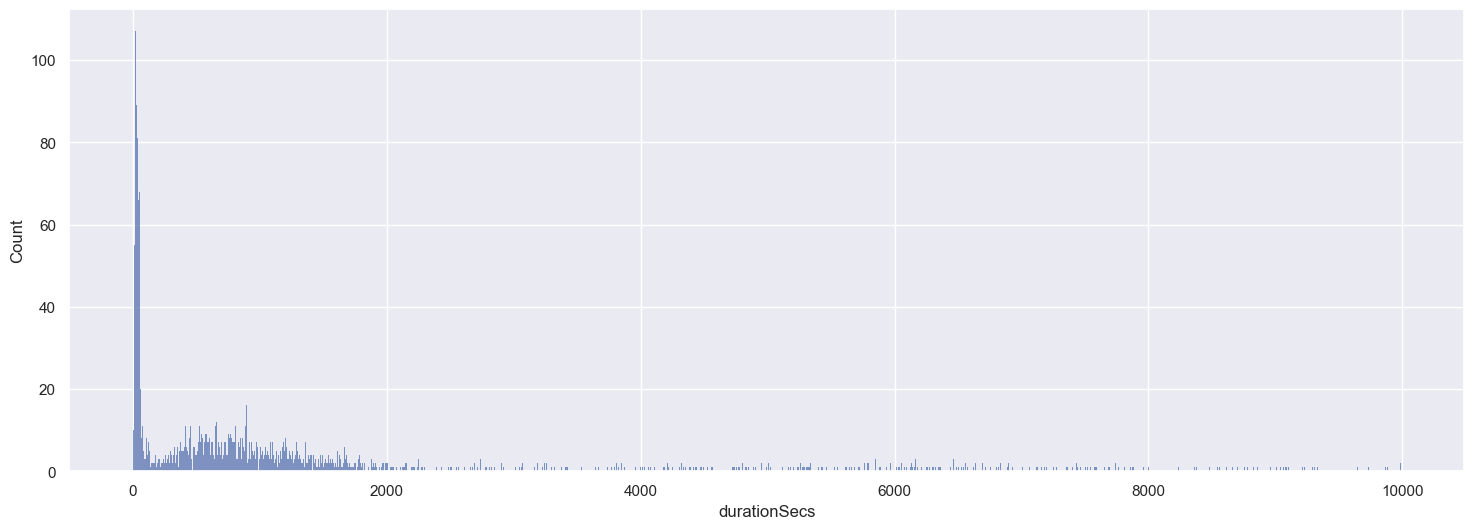

In [21]:
sns.histplot(data=video_df[video_df['durationSecs'] < pd.Timedelta(seconds=10000)], x="durationSecs", bins=30) 

<Axes: xlabel='durationSecs', ylabel='likeCount'>

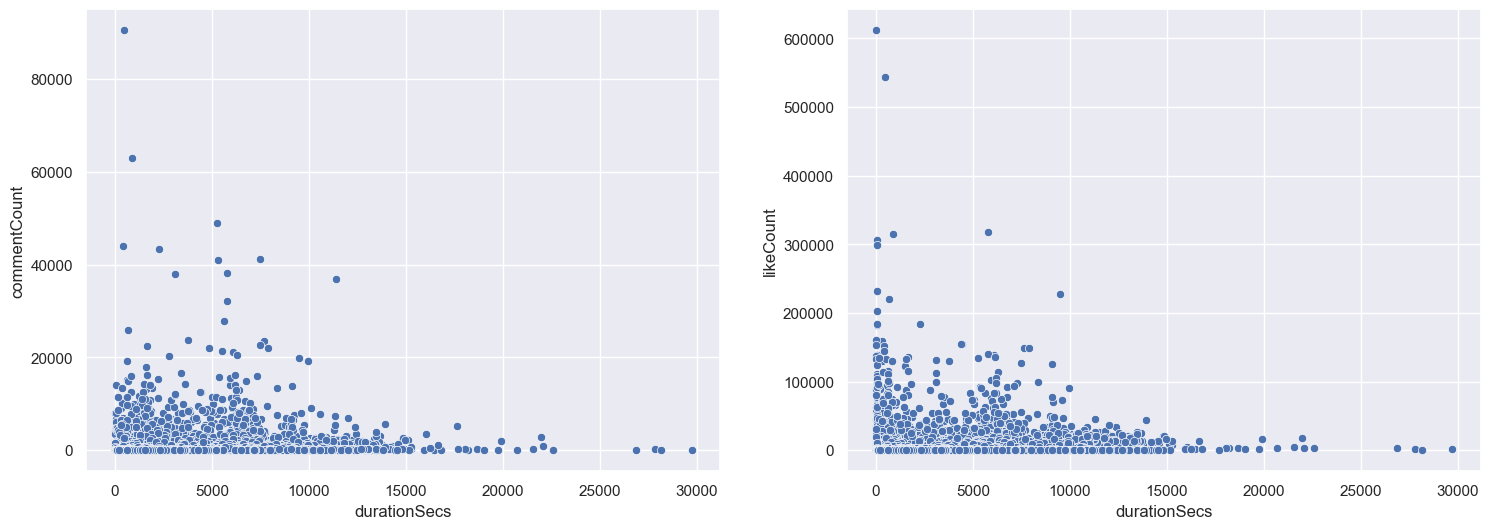

In [22]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

<Axes: xlabel='titleLength', ylabel='viewCount'>

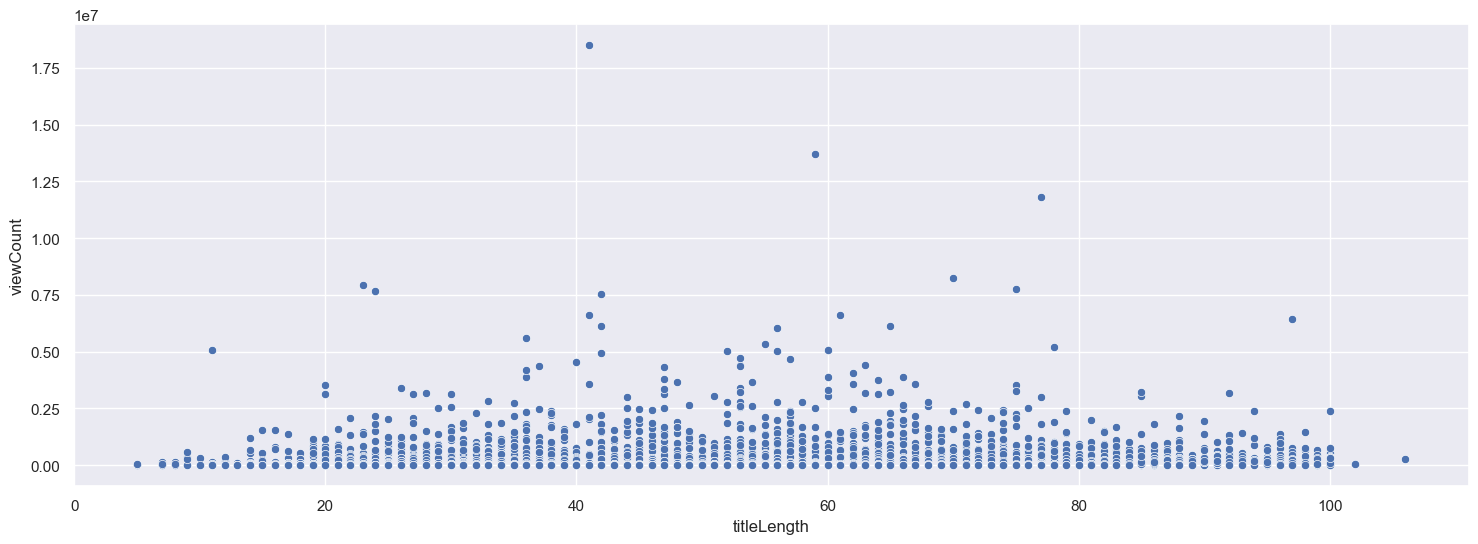

In [23]:
sns.scatterplot(data = video_df, x = "titleLength", y = "viewCount")

In [24]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

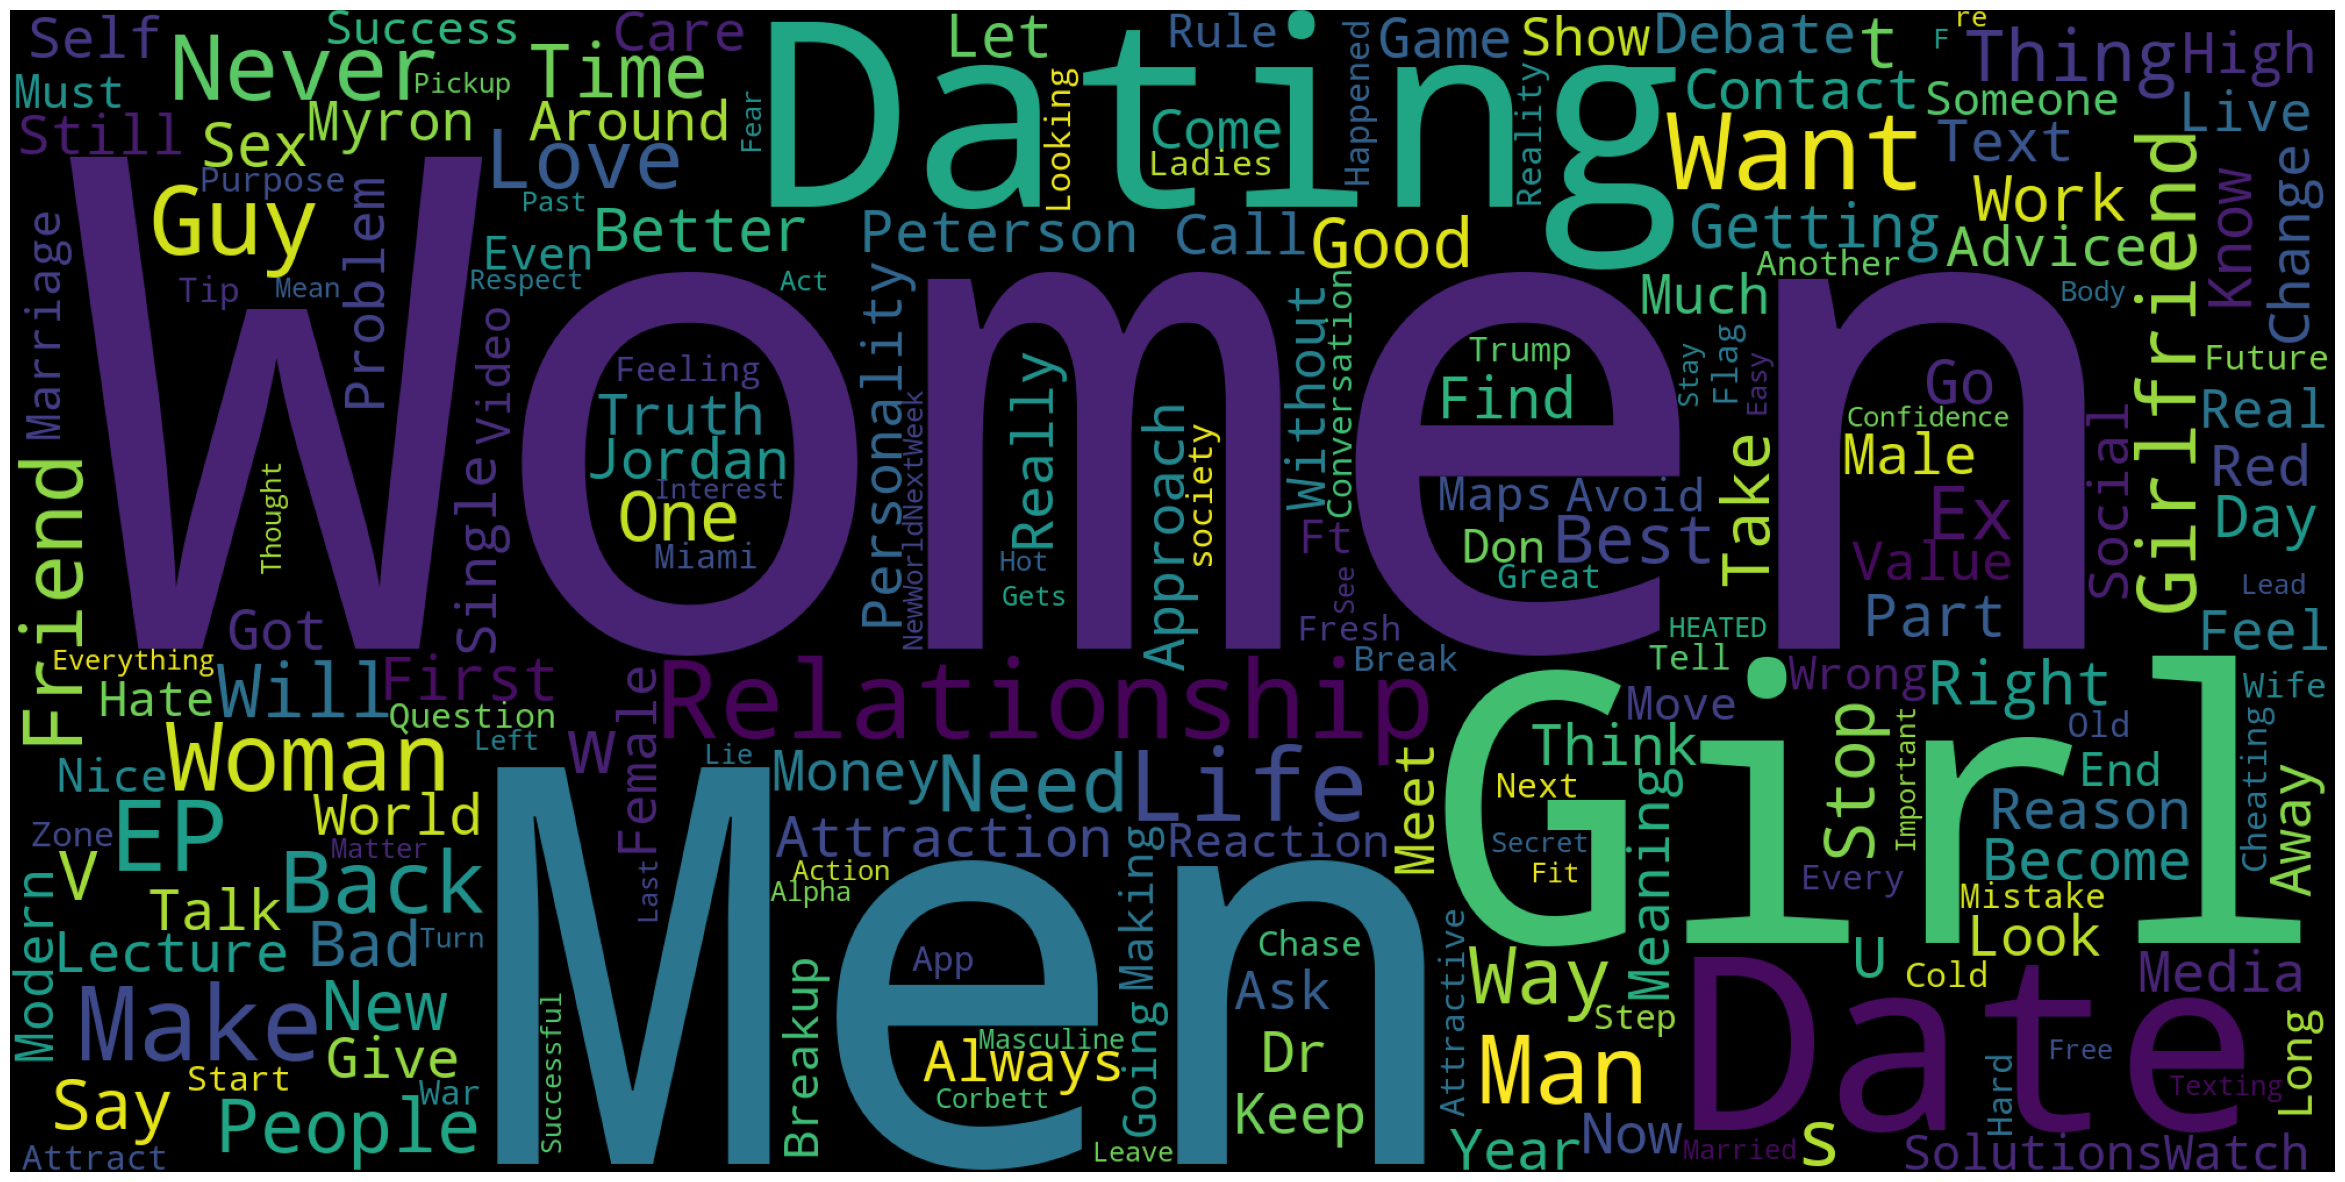

In [25]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black',
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

<Axes: xlabel='tagsCount', ylabel='viewCount'>

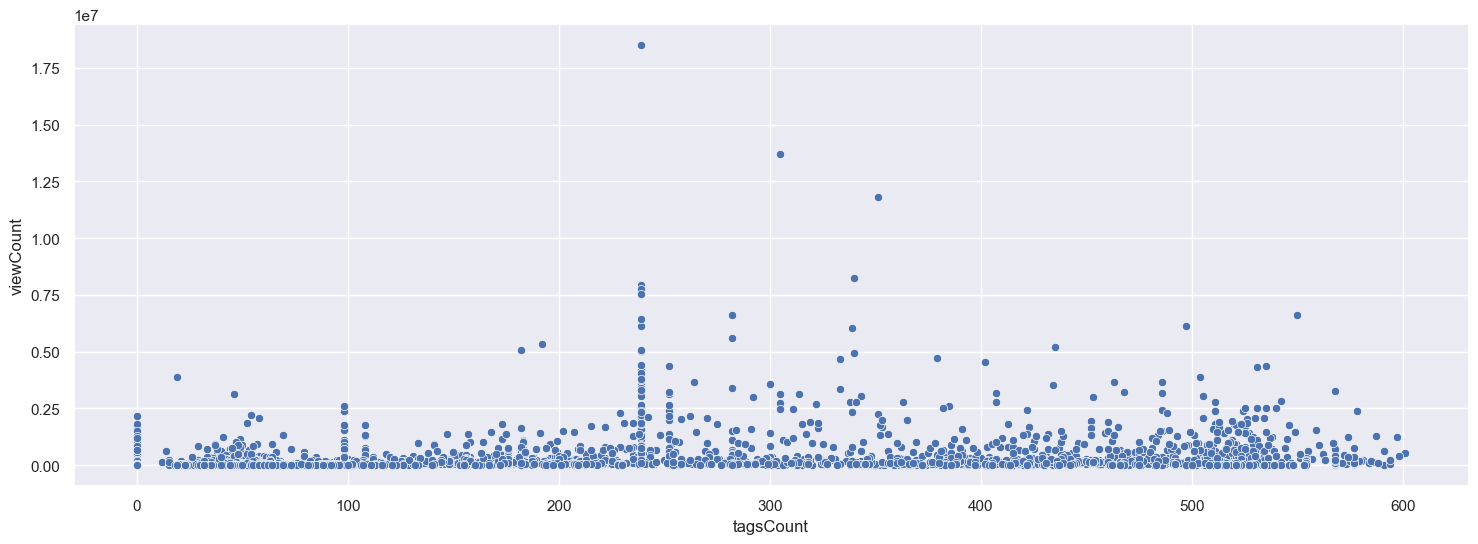

In [26]:
sns.scatterplot(data = video_df, x = "tagsCount", y = "viewCount")

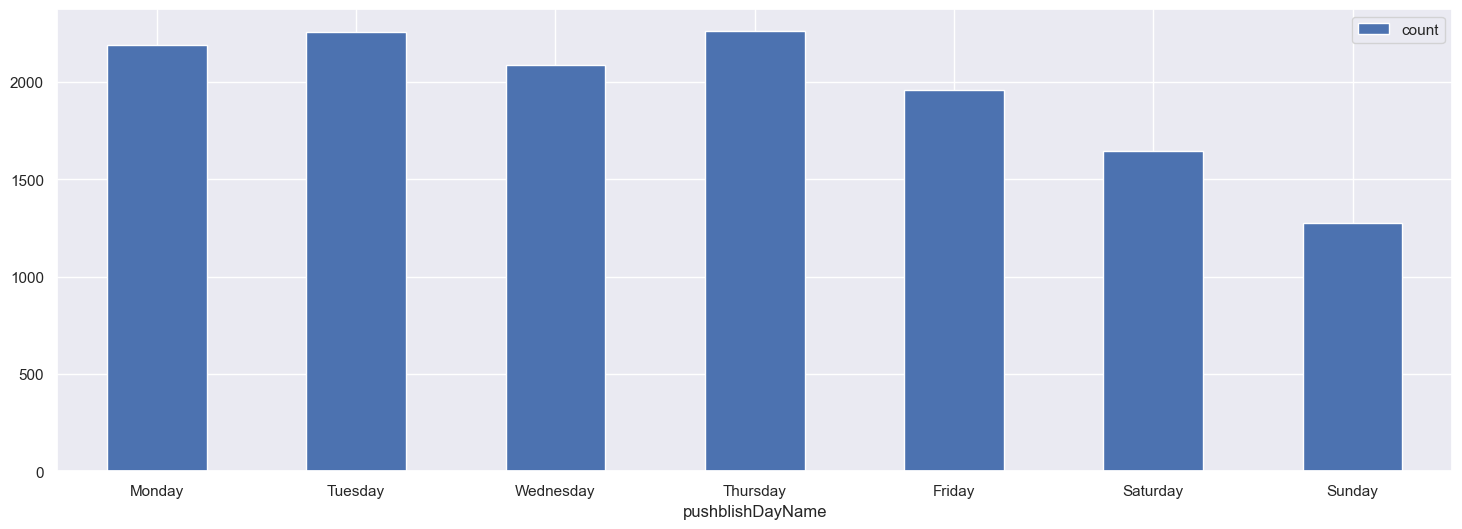

In [27]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
# Use 'pushblishDayName' as x and 'count' as y
ax = day_df.reset_index().plot.bar(x='pushblishDayName', y='count', rot=0)

In [34]:
stop_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comment'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

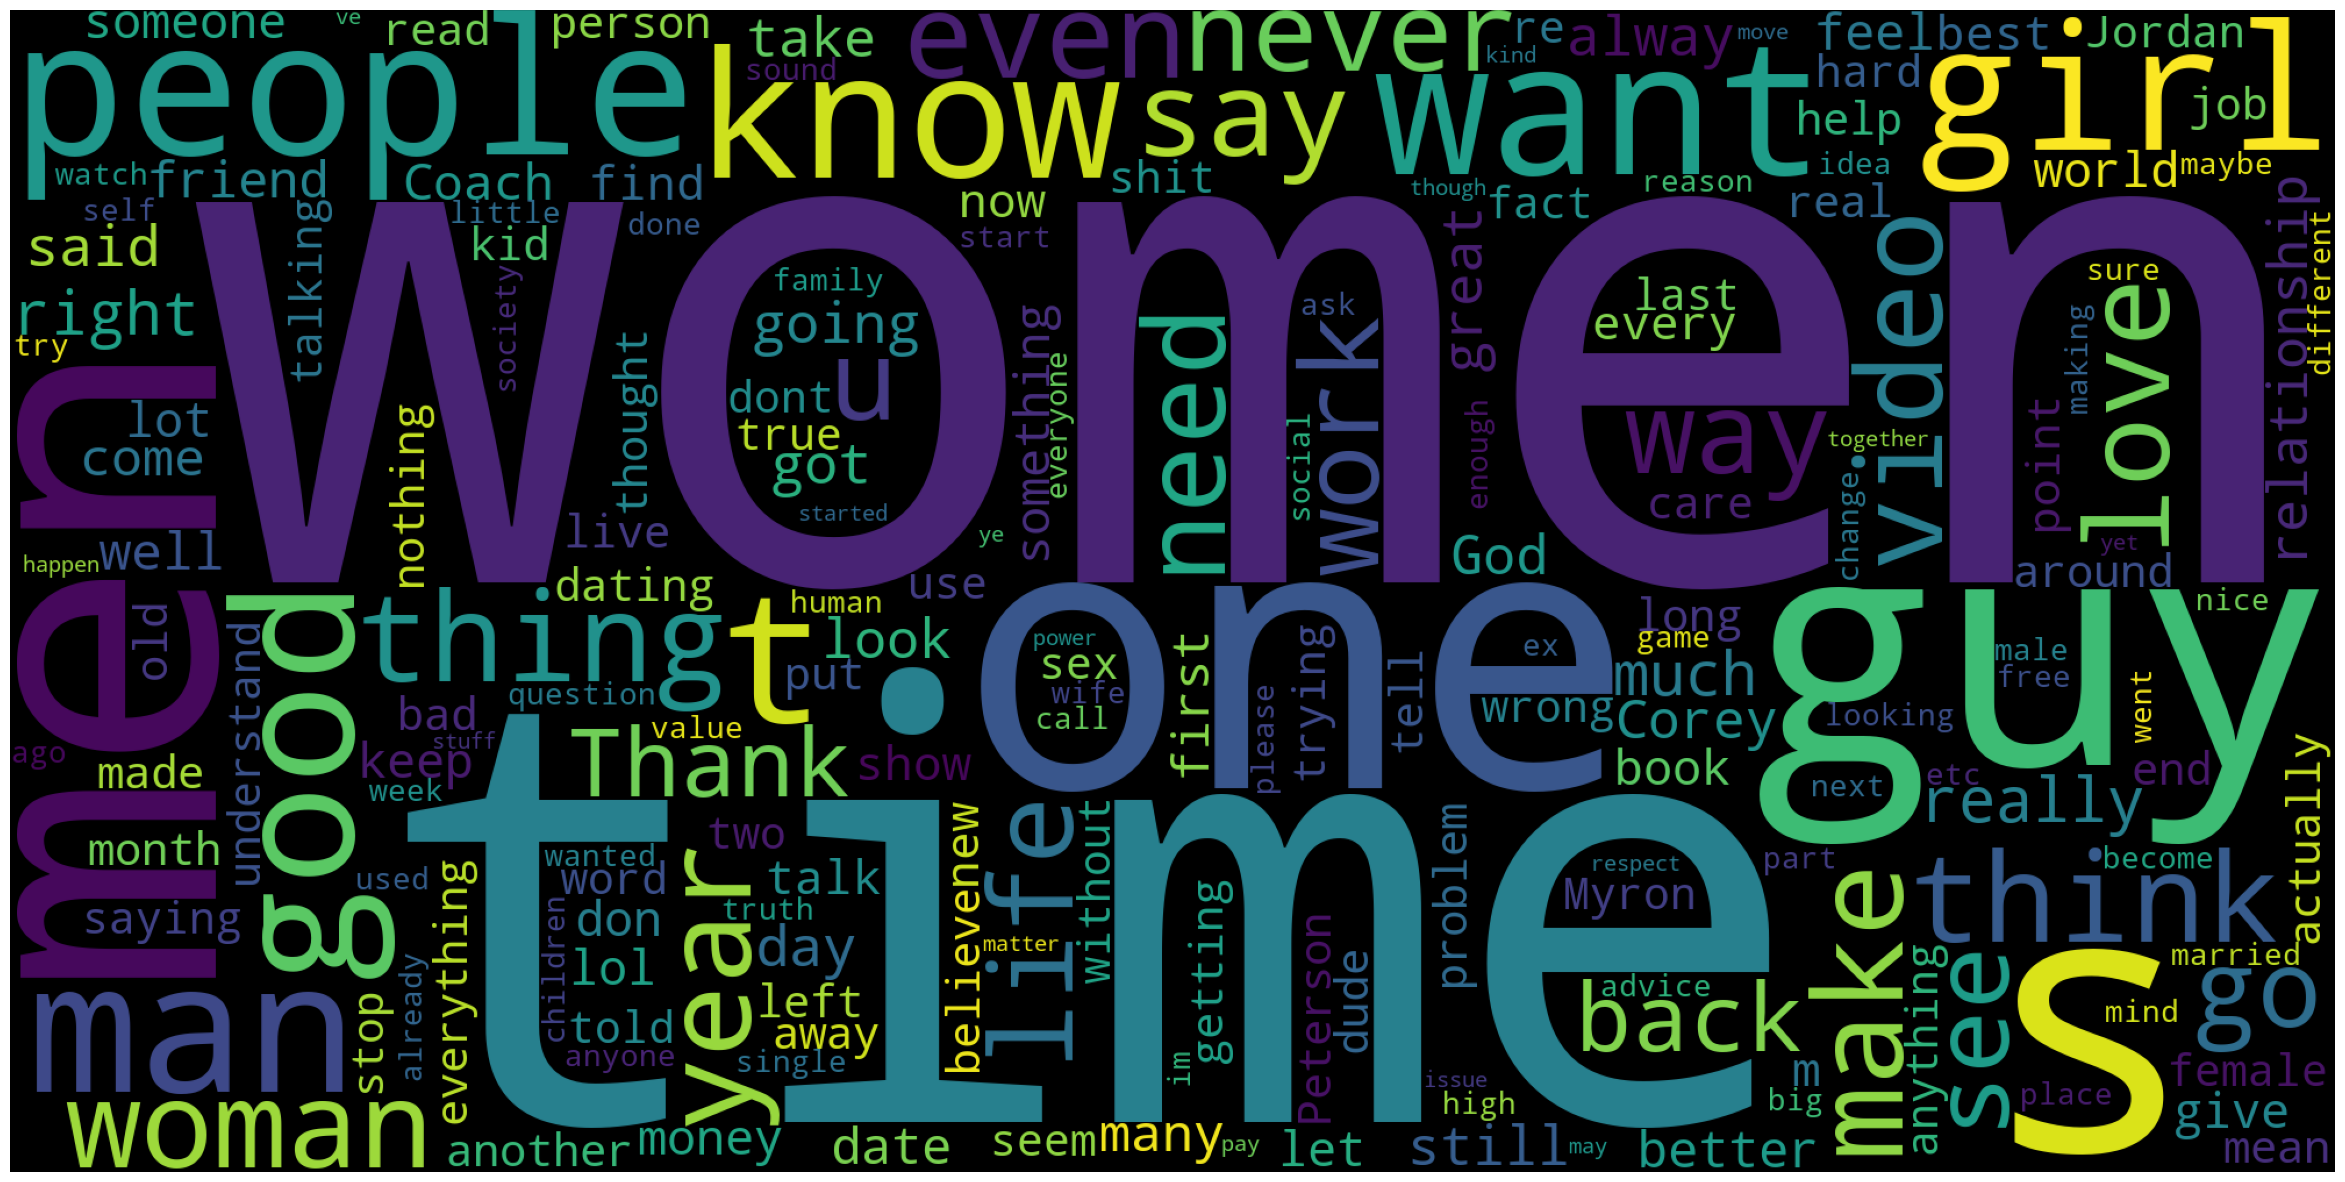

In [35]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black',
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)